**Entrenamiento de una red neuronal para que busque el logo de la UTN**


*Runtime->Change Runtime Type-> Hardware Accelerator -> GPU*

In [0]:
#Instala algunas librerías para python
!pip install protobuf pillow lxml Cython jupyter matplotlib pandas opencv-python -q
!apt-get install -y -qq protobuf-compiler python-pil python-lxml

In [0]:
#Clona el repositorio tensorflow/research/object_detection
!git clone https://github.com/tensorflow/models

In [0]:
#Clona el repositorio de herramientas de metrica COCO
!git clone https://github.com/cocodataset/cocoapi.git

In [0]:
#Compilar codigo de COCO API para python
%cd cocoapi/PythonAPI
!make 

In [0]:
#Copiar python coco tools en research
!cp -r pycocotools /content/models/research/

In [0]:
#Crea python path para el codigo object detection
import os
import sys
os.environ['PYTHONPATH'] = "/content/models/research:/content/models/research/slim:/content/models/research/object_detection"
os.environ["PATH"]+=":/content/models/research:/content/models/research/object_detection:/content/models/research/slim"
sys.path.insert(0,"/content/models/research/object_detection")

In [0]:
#Compila mensajes de protocol buffer
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
#Test de instalacion tensorflow/research/object_detection 
!python object_detection/builders/model_builder_test.py

In [0]:
#Descargar repositorio de ayuda para generar datos
%cd /content
!rm -rf utn_tf
!git clone https://github.com/xtianhb/utn_tf

In [0]:
#Opcional: para desarrollo, actualizar repositorio
%cd /content/utn_tf
!git pull

In [0]:
#Crea carpeta para train samples
%cd /content/utn_tf/samples
!mkdir train

In [0]:
#Genera imagenes sinteticas para train. 100 por cada fondo de ejemplo.
!python scripts/gen_set.py raw train 100

In [0]:
#Crea archivo csv para datos para entrenamiento
!python scripts/xml2csv.py train

In [0]:
#Crea archivo csv para datos de evaluacion
!python scripts/xml2csv.py eval

In [0]:
#Genera archivo tfrecord para entrenamiento
!python scripts/gen_tfrec.py --csv_input=train/train.csv --image_dir=train --output_path=train/train.record

In [0]:
#Genera archivo tfrecord para evaluacion
!python scripts/gen_tfrec.py --csv_input=eval/eval.csv --image_dir=eval --output_path=eval/eval.record

In [0]:
#Descarga modelo ssdlite mobilenet para hacer transfer learning
%cd /content/
!curl http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz -o ssdlite_mobilenet_v2.tar.gz

In [0]:
#Descomprime el zip del modelo
!gunzip ssdlite_mobilenet_v2.tar.gz
!tar -xvf  ssdlite_mobilenet_v2.tar

In [0]:
#Ejecuta entrenamiento y evaluación con script model_main.py
%cd /content/models/research
get_ipython().system_raw('python object_detection/model_main.py \
    --num_eval_steps=5 --num_train_steps=100000 \
    --logtostderr \
    --pipeline_config_path=/content/utn_tf/training/model.config \
    --model_dir=/content/utn_tf/training &')

In [0]:
#Opcional: Ver pid model_main y archivos
!ps -ef | grep model_main.py
!ls /content/utn_tf/training

In [0]:
#Alternativa: Ejecuta entrenamiento con script legacy/train.py
%cd /content/models/research
get_ipython().system_raw('python object_detection/legacy/train.py \
    --logtostderr \
    --pipeline_config_path=/content/utn_tf/training/model.config \
    --train_dir=/content/utn_tf/training &')

In [0]:
#Opcional: ver pid Legacy Train
!ps -ef | grep train.py
!ls /content/utn_tf/training

In [0]:
#Alternativa: Ejecuta evaluacion con script legacy/eval.py
%cd /content/models/research
get_ipython().system_raw('python object_detection/legacy/eval.py \
    --logtostderr \
    --pipeline_config_path=/content/utn_tf/training/model.config \
    --checkpoint_dir=/content/utn_tf/training \
    --eval_dir=/content/utn_tf/training &')

In [0]:
#Opcional: Ver pid Legacy Eval
!ps -ef | grep eval.py
!ls /content/utn_tf/training

In [0]:
#Ejecutar TensorBoard para ver informacion del entrenamiento
get_ipython().system_raw('tensorboard --logdir /content/utn_tf/training --host 0.0.0.0 --port 6006 &')

In [0]:
#Opcional: ver pid tensorboard
!ps -ef | grep tensorboard
!ls /content/utn_tf/training

In [0]:
#Descargar Ngrok, para crear tunel a TensorBoard
%cd /content/utn_tf 
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
#Ejecuta Ngrok
%cd /content/utn_tf 
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
#Opcional: Ver pid de ngrok
!ps -ef | grep ngrok

In [0]:
#Obtiene link http tunel ngrok
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

El entrenamiento ejecuta 100k pasos y se detiene. Aquí termina el entrenamiento. En una instancia con GPU tarda aproximadamente 2 horas.

**Descargar el modelo entrenado**

In [0]:
%cd /content/models/research/

In [0]:
#Buscar el ultimo checkpoint #
!ls /content/utn_tf/training

In [0]:
#Generar inference graph. Reemplazar manualmente los ## en model.ckpt-#####
!mkdir /content/utn_tf/training/inf_graph
!python object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path /content/utn_tf/training/model.config \
    --trained_checkpoint_prefix /content/utn_tf/training/model.ckpt-46890 \
    --output_directory /content/utn_tf/training/inf_graph

In [0]:
#Muestra contenidos de la carpeta inference graph
!ls /content/utn_tf/training/inf_graph

In [0]:
#zipea inference graph
!zip -r /content/utn_tf/training/inf_graph.zip /content/utn_tf/training/inf_graph

In [0]:
#Vamos a descargar el modelo localmente
#Librerias para subir a gdrive
#Ir al link que aparece, y llenar el codigo en el campo de texto.
#Esto habilita el acceso de Colab a GDrive.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Subir el .zip a GDrive
uploaded = drive.CreateFile({'title': 'inf_graph.zip'})
uploaded.SetContentFile('/content/utn_tf/training/inf_graph.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

**Inferencia en la nube**

In [0]:
#import librerias
%cd /content/models/research
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
import glob
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [0]:
# Import utilites
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
#parametros inferencia
# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT="/content/utn_tf/training/inf_graph/frozen_inference_graph.pb"

# Path to label map file
PATH_TO_LABELS="/content/utn_tf/samples/label_map.txt"

# Number of classes the object detector can identify
#NUM_CLASSES = int(sys.argv[3])
NUM_CLASSES=1

#IMAGENES INPUT
IMGS_INPUT="/content/utn_tf/test"

## Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

In [0]:
#tensores inferencia
# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

Buscando imagenes jpg disponible en input_dir


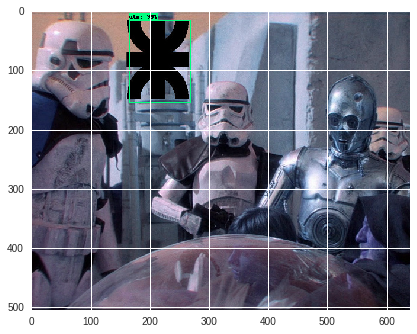

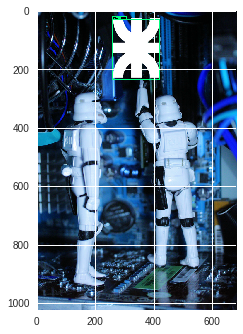

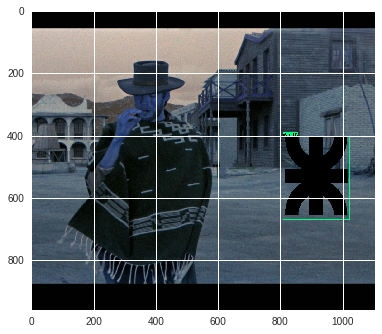

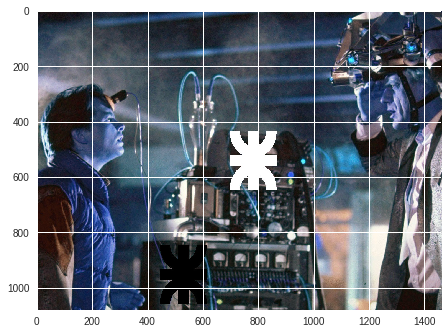

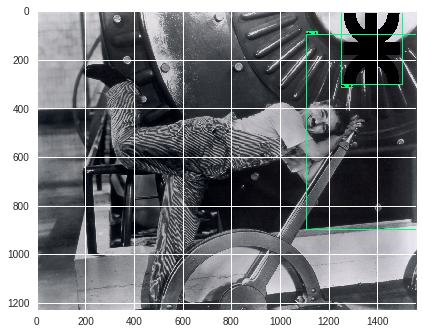

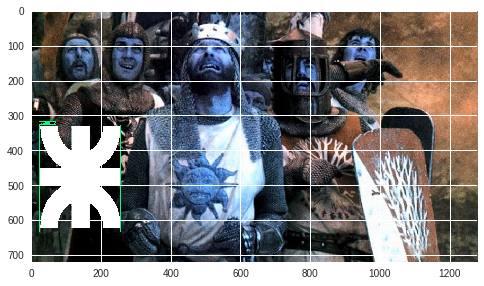

End


In [85]:
#programa inferencia imagenes
# Inicializa imagenes
print("Buscando imagenes jpg disponible en input_dir")
ImgsPaths=glob.glob(IMGS_INPUT+"/*.jpg")

if len(ImgsPaths)==0:
	print("no hay imagenes .jpg en input dir")
	exit(-1)

for ImgPath in ImgsPaths:

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    Img = Image.open(ImgPath)
    
    (W, H) = Img.size
    Image_np = np.array(Img)
    Img_expanded = np.expand_dims(Image_np, axis=0)

    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: Img_expanded})
	
    # Draw the results of the detection (aka 'visulaize the results')
    vis_util.visualize_boxes_and_labels_on_image_array(
        Image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=2,
        min_score_thresh=0.7)
	
    # All the results have been drawn on the frame, so it's time to display it.
    img_cvt=cv2.cvtColor(Image_np, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()


print("End")